In [4]:
!pip install coloraide

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 2.0 MB/s eta 0:00:00 MB/s eta 0:00:010:01


In [108]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from cynetdiff.utils import networkx_to_ic_model
import numpy as np
from coloraide import Color

Graph = nx.Graph | nx.DiGraph

In [113]:
def create_plot_for_nodes_infected_perc(
    graphs: Graph | list[Graph],
    plot_iqr: bool = False,
):
    # TODO Dhemath, see if there's a way to fix the bar running out on the shorter experiments.
    """
    Create a plot of the percentage of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """

    if not isinstance(graphs, list):
        graphs = [graphs]

    # Generate distinct colors for each graph using Coloraide
    colors = [Color.random("srgb") for _ in graphs]

    # Generate distinct lighter-colors for each graph for IQR plotting
    light_colors = []
    for color_str in colors:
        color = Color(color_str, "srgb")
        color[3]=0.5
        light_colors.append(color)
        

    max_length = 0
    all_graphs_data = []

    #Get all the data for graphs
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 100

        all_trials_infected_nodes = []

        for _ in range(num_trials):
            model.reset_model()

            infected_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                number_infected = current_activated
                infected_nodes_over_time.append(number_infected)

            all_trials_infected_nodes.append(infected_nodes_over_time)
            max_length = max(max_length, len(infected_nodes_over_time))

        all_graphs_data.append(all_trials_infected_nodes)

    #Pad all data
    padded_all_graphs_data = []
    for graph_data in all_graphs_data:
        padded_trials = [
            trial + [trial[-1]] * (max_length - len(trial))
            for trial in graph_data
        ]
        padded_all_graphs_data.append(padded_trials)

    #Graph Data
    for idx, graph_data in enumerate(padded_all_graphs_data):
        median_infected = np.median(graph_data, axis=0)
        
        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [
                        trial[i] if i < len(trial) else trial[-1]
                        for trial in graph_data
                    ],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_infected:
                plt.axhline(y=y, color=colors[idx], linestyle="--", alpha=0.2)

            plt.fill_between(
                range(max_length),
                lower_quartile,
                upper_quartile,
                color=light_colors[idx],
                alpha=0.3,
            )

        plt.plot(
            median_infected, label=f"Graph {idx+1} Median Infected", color=colors[idx]
        )

    plt.xlabel("Iteration")
    plt.ylabel("Number of Infected Nodes")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [114]:
def create_plot_for_delta_nodes_infected(
    graph1: nx.Graph,
    graph2: nx.Graph = None,
    graph3: nx.Graph = None,
    graph4: nx.Graph = None,
    plot_iqr: bool = False,
):
    """
    Create a plot of the delta of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """
    graphs = [g for g in [graph1, graph2, graph3, graph4] if g is not None]
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        # Assuming set_seeds is defined elsewhere or seeds need to be defined/adjusted per graph
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 1

        all_trials_delta_nodes = []
        max_length = 0

        for _ in range(num_trials):
            model.reset_model()

            delta_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                delta_nodes_over_time.append(current_activated - previous_activated)

            max_length = max(max_length, len(delta_nodes_over_time))
            all_trials_delta_nodes.append(delta_nodes_over_time)

        padded_trials = [
            trial + [0] * (max_length - len(trial)) for trial in all_trials_delta_nodes
        ]

        median_delta = np.median(padded_trials, axis=0)

        if plot_iqr:
            # Calculate and plot the IQR only if plot_iqr is True
            iqr_values = [
                np.percentile(
                    [trial[i] if i < len(trial) else 0 for trial in padded_trials],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_delta:
                plt.axhline(y=y, color="gray", linestyle="--", alpha=0.2)

            plt.fill_between(
                range(len(lower_quartile)),
                lower_quartile,
                upper_quartile,
                color="#7daec7",
                alpha=0.3,
            )

        plt.plot(median_delta, label="Median Delta Nodes", color="#3f83a6")

    plt.xlabel("Iteration")
    plt.ylabel("Delta Nodes Infected")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [117]:
# O = nx.fast_gnp_random_graph(15000, 2)
graphs = []

base_graph = nx.watts_strogatz_graph(15_000, 10, 0.01)



graphs=[
   nx.watts_strogatz_graph(15_000, 10, 0.01),
   nx.watts_strogatz_graph(15_000, 10, 0.02),
   nx.watts_strogatz_graph(15_000, 10, 0.05),
   nx.watts_strogatz_graph(15_000, 10, 0.10),
   nx.watts_strogatz_graph(15_000, 10, 0.20),
]
# B = nx.erdos_renyi_graph(100, 0.1)
# nx.set_edge_attributes(G, 0.01, "activation_prob")
# nx.set_edge_attributes(O, 0.01, "activation_prob")
# nx.set_edge_attributes(B, 0.01, "activation_prob")

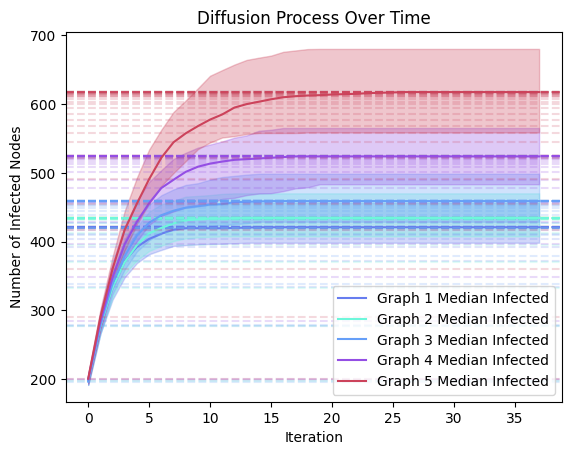

In [118]:
create_plot_for_nodes_infected_perc(graphs,True)

In [130]:
def compute_marginal_gain(graph, new_node, seeds, num_trials: int = 100) -> float:
    """
    Compute the marginal gain in the spread of influence by adding a new node to the set of seed nodes,
    by summing the differences of spreads for each trial and then taking the average.
    
    Parameters:
    - model: The model instance used for simulating the spread of influence.
    - new_node: The new node to consider adding to the set of seed nodes.
    - seeds: The current set of seed nodes.
    - num_trials: The number of trials to average the spread of influence over.
    
    Returns:
    - The average marginal gain in the spread of influence by adding the new node.
    """
    marginal_gain_sum = 0.0

    for _ in range(num_trials):
        model = networkx_to_ic_model(graph)
        model.set_seeds(seeds)
        model.reset_model()
        model.advance_until_completion()
        original_spread = model.get_num_activated_nodes()
        
        new_seeds = seeds.union({new_node})
        model.set_seeds(new_seeds)
        model.reset_model()
        model.advance_until_completion()
        new_spread = model.get_num_activated_nodes()
        
        marginal_gain_sum += (new_spread - original_spread)

    avg_marginal_gain = marginal_gain_sum / num_trials

    return avg_marginal_gain


In [131]:
sorted(graphs[0].nodes())[-1]

14999

In [133]:
compute_marginal_gain(graphs[0], , set(random.sample(list(graphs[0].nodes()), 100)))

-4.1

In [136]:
# Cell with CELF algorithm.
# Code adapted from https://hautahi.com/im_greedycelf


def celf_adapted(graph: nx.Graph, k: int, mc: int = 1000) -> set[int]:
    """
    Adaptation of the CELF algorithm using CyNetDiff function.

    Parameters:
    - graph: The graph object on which diffusion will be simulated.
    - k: The number of seed nodes to find.
    - mc: The number of Monte Carlo simulations to estimate the spread of influence.

    Returns:
    - A set of k seed nodes that are estimated to maximize the spread of influence.
    """

    model = networkx_to_ic_model(graph)
    
    def calculate_spread(seeds):
        model.set_seeds(seeds)
        total_activated = 0.0
        for _ in range(mc):
            model.reset_model()
            model.advance_until_completion()
            total_activated += model.get_num_activated_nodes()
        return total_activated / mc
    
    marg_gain = [calculate_spread({node}) for node in graph.nodes()]
    Q = sorted(zip(graph.nodes(), marg_gain), key=lambda x: x[1], reverse=True)
    
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS = Q[1:], [len(Q)]

    for _ in range(k - 1):
        check = False
        node_lookup = 0
        while not check:
            node_lookup += 1
            current = Q[0][0]
            new_spread = calculate_spread(set(S + [current])) - spread
            Q[0] = (current, new_spread)
            Q = sorted(Q, key=lambda x: x[1], reverse=True)
            check = Q[0][0] == current
        
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        Q = Q[1:]
    
    return (S, SPREAD, LOOKUPS)

In [137]:
celf_adapted(graphs[0],1,10)

([10926], [13.4], [15000])